In [1]:
import cv2
from sklearn.model_selection import train_test_split
import glob
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD,Adam
#data augmantation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# for not showing the tensorflow execution messages
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
def load_data(road):
    data_list= []
    labels=[]
    for i,address in enumerate(glob.glob(road+"/*/*")):
            try:
                img = cv2.imread(address)
                img = cv2.resize(img,(32,32))
                img_r=img/255           
                data_list.append(img_r)
                label = address.split("/")[-1].split(".")[0].split("_")[0]
                labels.append(label)
                if i%100 == 0:
                    print("statue: {}/1500 processed".format(i))
            except:
                print("Error")
                continue

    data_list=np.array(data_list)

    x_train,x_test,y_train,y_test=train_test_split(data_list,labels,test_size=0.2,random_state=0)
    
    #for molticlassifacation
    #le = preprocessing.LabelBinarizer()
    #le.fit([1, 2, 6, 4])
    #lb.transform([1, 6])
    #>>>array([[1, 0, 0, 0],
    #         [0, 0, 0, 1]])
        
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return x_train,x_test,y_train,y_test

In [7]:
def Defining_model(x_train,x_test,y_train,y_test):
    net = models.Sequential([layers.Conv2D(32,(3,3),activation="relu",input_shape=(32,32,3)),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(),
                             
                             layers.Conv2D(32,(3,3),activation="relu"),
                             layers.BatchNormalization(),
                             layers.MaxPool2D(),
                             
                             layers.Flatten(),
                             layers.Dense(100,activation="relu"),
                             layers.BatchNormalization(),
                             layers.Dense(2,activation="sigmoid"),
                            ])
    
    aug = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")
    
    opt = SGD(learning_rate=0.01,decay=0.00025)
       
    net.compile(optimizer=opt,
            loss ="categorical_crossentropy",#"spars_categorical_crossentropy" no need to one hot
            metrics=["accuracy"])
    
    res = net.fit(aug.flow(x_train,y_train,batch_size=32),steps_per_epoch=len(x_train)//32,validation_data=(x_test,y_test),epochs=100)
    
    print("\nKeys of resault:\n",res.history.keys(),"\n")
    
    print(net.summary())
    
    return net,res

In [8]:
def plotting(res,strr):
    plt.style.use("ggplot")
    plt.plot(res.history[strr],label= strr+" Train")
    plt.plot(res.history["val_"+strr],label= strr+" Validation")
    plt.title(strr+" Charts")
    plt.xlabel("epochs")
    plt.ylabel(strr)
    plt.legend()
    plt.show()

In [5]:
def testing(model,road):
    img = cv2.imread(road)
    img = cv2.resize(img,(32,32))
    img_r=img/255
    img_r = np.array([img_r]) #We gave it Batch in training, so We don't give it array in testing!
    out = np.argmax(model.predict(img_r)[0])
    names = ["fire","non fire"]
    return names[out]

In [6]:
x_train,x_test,y_train,y_test = load_data("/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training")

statue: 0/1500 processed
statue: 100/1500 processed
statue: 200/1500 processed
statue: 300/1500 processed
statue: 400/1500 processed
statue: 500/1500 processed
statue: 600/1500 processed
statue: 700/1500 processed
statue: 800/1500 processed
statue: 900/1500 processed
statue: 1000/1500 processed
statue: 1100/1500 processed
statue: 1200/1500 processed
statue: 1300/1500 processed
statue: 1400/1500 processed
statue: 1500/1500 processed


In [9]:
y_train.ndim

2

In [10]:
net,res = Defining_model(x_train,x_test,y_train,y_test)

Epoch 1/100
38/38 [==============================] - 2s 37ms/step - loss: 0.2837 - accuracy: 0.8840 - val_loss: 0.6494 - val_accuracy: 0.4737
Epoch 2/100
38/38 [==============================] - 1s 31ms/step - loss: 0.1930 - accuracy: 0.9202 - val_loss: 0.6816 - val_accuracy: 0.4671
Epoch 3/100
38/38 [==============================] - 1s 31ms/step - loss: 0.1974 - accuracy: 0.9309 - val_loss: 0.7912 - val_accuracy: 0.4638
Epoch 4/100
38/38 [==============================] - 1s 30ms/step - loss: 0.1661 - accuracy: 0.9342 - val_loss: 0.7592 - val_accuracy: 0.4836
Epoch 5/100
38/38 [==============================] - 1s 30ms/step - loss: 0.1638 - accuracy: 0.9367 - val_loss: 0.6809 - val_accuracy: 0.5625
Epoch 6/100
38/38 [==============================] - 1s 30ms/step - loss: 0.1518 - accuracy: 0.9465 - val_loss: 0.5878 - val_accuracy: 0.6382
Epoch 7/100
38/38 [==============================] - 1s 29ms/step - loss: 0.1377 - accuracy: 0.9474 - val_loss: 0.4342 - val_accuracy: 0.7895
Epoch 

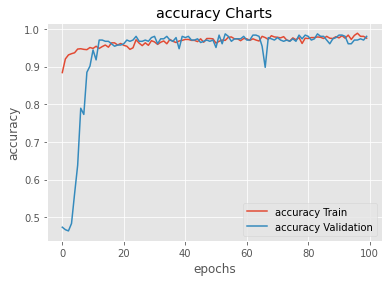

In [11]:
plotting(res,"accuracy")

In [70]:
loss,acc = net.evaluate(x_test,y_test)

10/10 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.9704


In [ ]:
net.save("mlp.h5")
model = models.load_model(r"/kaggle/working/mlp.h5")

In [ ]:
out = testing(net,"/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Testing/nofire_0132.jpg")
print(out)